In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LayerNormalization

In [10]:
## DATA PREPROCESSING
df = pd.read_csv('RBL Data Edited-Combined.csv', sep=";" , skiprows=1 , decimal=",", encoding="utf-8" , usecols=lambda col: col != 'Patient_ID')
## Dropping null values from the dataset
df = df.dropna(how="all")
df.isnull().sum()

#after the above we then separate the targets from input features also dropping unimportant features from the set
x = df.drop(columns=["Fertilization Rate (%)" , "Blastulation_Rate (%)","Year"])
y = df[["Fertilization Rate (%)","Blastulation_Rate (%)"]]

## Added step for dealing with missing values 
num_cols= x.select_dtypes(include=["float64", "int64"]).columns
cat_cols= x.select_dtypes(include=["object"]).columns

num_imputer= SimpleImputer(strategy="median")
cat_imputer= SimpleImputer(strategy="most_frequent")

x[num_cols]= num_imputer.fit_transform(x[num_cols])
x[cat_cols]= cat_imputer.fit_transform(x[cat_cols])

## In the below we encode our categorical columns 
le_col= {}
for col in cat_cols:
        le = LabelEncoder()
        x[col] = le.fit_transform(x[col].astype(str))
        le_col[col] = le

## Convert encoded columns to dataframes to inspect 
# Making sure all the data is correct and no nulls for input features 
encoded_df = x.copy()
encoded_df.head()
print(encoded_df.dtypes)
print(encoded_df.describe())
print(encoded_df.isnull().sum())

## Making sure target variables are correct with no nulls 
print(y.head())          # sample values
print(y.dtypes)          # ensure nsumeric
print(y.nunique())
print(y.isnull().sum())

print(df.shape)
print("Total features:", len(x.columns))

Donor Semen                           int64
Semen_Collection_Method               int64
Ejaculatory_Abstinence (days)       float64
Semen_Volume (ml)                   float64
Sperm_Concentration (million/ml)      int64
Sperm_Prog_Motility (%)               int64
Sperm_Morphology (%)                float64
Round_Cells (million/ml)              int64
Male_Infertility                      int64
Female_ Infertility                   int64
Follicles_Collected (#)             float64
Male_Age (years)                    float64
Female_Age (years)                  float64
Male_Tobacco                          int64
Male_Alcohol                          int64
dtype: object
       Donor Semen  Semen_Collection_Method  Ejaculatory_Abstinence (days)  \
count   272.000000               272.000000                     272.000000   
mean      0.036765                 1.147059                       6.062500   
std       0.188530                 0.508662                       7.717316   
min       0.00

In [11]:
# Scale targets to (0,1) for beta regression
y_fert_binned = y["Fertilization Rate (%)"].str.replace("%","", regex=False).astype(float) / 100.0 
y_blast_binned = y["Blastulation_Rate (%)"].str.replace("%","", regex=False).astype(float) / 100.0

##this is when fertalisation rate is 0% and blastulation was left blank
structured_zero_mask = (y_fert_binned == 0) & (y_blast_binned.isna())

## Assigning blastulation to 0 
y_blast_binned.loc[structured_zero_mask] = 0.0

print("Structured zeros have been fixed", structured_zero_mask.sum())

Structured zeros have been fixed 19


In [12]:
# =========================
# DATA SPLITTING
# =========================

# Use FULL dataset (no filtering)
X = encoded_df
y_fert = y_fert_binned
y_blast = y_blast_binned

# 1. FIRST SPLIT: Temp + Holdout (20% holdout)
x_temp, x_holdout, y_fert_temp, y_fert_holdout, y_blast_temp, y_blast_holdout = train_test_split(
    X,
    y_fert,
    y_blast,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 2. SECOND SPLIT: Train + Test (30% of temp → test)
x_train, x_test, y_fert_train, y_fert_test, y_blast_train, y_blast_test = train_test_split(
    x_temp,
    y_fert_temp,
    y_blast_temp,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

# 3. THIRD SPLIT: Train + Validation (20% of train → val)
x_train, x_val, y_fert_train, y_fert_val, y_blast_train, y_blast_val = train_test_split(
    x_train,
    y_fert_train,
    y_blast_train,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# =========================
# SANITY CHECKS
# =========================
print("Data shapes after splitting:")
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)
print("x_holdout shape:", x_holdout.shape)

print("Fertilization (train):",
      y_fert_train.min(), y_fert_train.max(), np.mean(y_fert_train))
print("Blastulation (train):",
      y_blast_train.min(), y_blast_train.max(), np.mean(y_blast_train))

Data shapes after splitting:
x_train shape: (120, 15)
x_val shape: (31, 15)
x_test shape: (66, 15)
x_holdout shape: (55, 15)
Fertilization (train): 0.0 1.5 0.5782500000000002
Blastulation (train): 0.0 1.13 0.3720833333333333


In [13]:
#Zero fixed for beta loss
y_blast_train = y_blast_train.mask(y_fert_train ==0, 0.0)
y_blast_val = y_blast_val.mask(y_fert_val ==0, 0.0)

##Converting Panda series to numpy arrays
y_fert_train =np.array(y_fert_train , dtype=np.float32)
y_fert_val   =np.array(y_fert_val , dtype=np.float32)
y_blast_train = np.array(y_blast_train , dtype=np.float32)
y_blast_val   = np.array(y_blast_val , dtype=np.float32)

## Scaling my y-values 
epsilon = 1e-6
y_fert_train = np.clip(y_fert_train, epsilon, 1 - epsilon)
y_fert_val = np.clip(y_fert_val, epsilon, 1 - epsilon)

y_blast_train = np.clip(y_blast_train, epsilon, 1 - epsilon)
y_blast_val = np.clip(y_blast_val, epsilon, 1 - epsilon)

print("Scaled Fertilization range:", y_fert_train.min(), "→", y_fert_train.max())
print("Scaled Blastulation range:", y_blast_train.min(), "→", y_blast_train.max())

Scaled Fertilization range: 1e-06 → 0.999999
Scaled Blastulation range: 1e-06 → 0.999999


In [14]:
##SCALING MY DATA 
## we will be capping the outliers within the 1st and the 99th percentiles 
def fit_outlier_caps(x, lower=0.01, upper=0.99):
    bounds = []
    x_np = x.to_numpy()
    for i in range(x_np.shape[1]):
        lo, hi = np.quantile(x_np[:, i], [lower, upper])
        bounds.append((lo, hi))
    return bounds

def apply_outlier_caps(x, bounds):
    x_np = x.to_numpy()
    for i, (lo, hi) in enumerate(bounds):
        x_np[:, i] = np.clip(x_np[:, i], lo, hi)
    return x_np


outlier_bounds = fit_outlier_caps(x_train)

x_train_capped = apply_outlier_caps(x_train, outlier_bounds)
x_val_capped = apply_outlier_caps(x_val, outlier_bounds)
x_test_capped = apply_outlier_caps(x_test, outlier_bounds)
x_holdout_capped = apply_outlier_caps(x_holdout, outlier_bounds)
## Initialising standard Scaler and scaling our input features for model training
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_capped)
x_test_scaled = scaler.transform(x_test_capped)
x_val_scaled = scaler.transform(x_val_capped)
x_holdout_scaled = scaler.transform(x_holdout_capped)

## Visualising data before and after Scaling 
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train.columns)
print("Before Scaling:\n", x_train.head())
print("\nAfter Scaling:\n", x_train_scaled_df.head())

assert x_train_scaled.shape[0] == y_fert_train.shape[0] == y_blast_train.shape[0]
assert x_val_scaled.shape[0] == y_fert_val.shape[0] == y_blast_val.shape[0]

print("All data shapes match!")
print('x_train_scaled shape: ', x_train_scaled.shape)
print('y_train_scaled shape: ', y_fert_train.shape)
print('y_train_scaled shape: ', y_blast_train.shape)
print(y_fert_train.shape, y_fert_train[:10], y_fert_train.dtype)
print(y_blast_train.shape, y_blast_train[:10], y_blast_train.dtype)

print("Final Fert range:", y_fert_train.min(), y_fert_train.max())
print("Final Blast range:", y_blast_train.min(), y_blast_train.max())

Before Scaling:
      Donor Semen  Semen_Collection_Method  Ejaculatory_Abstinence (days)  \
51             0                        1                           21.0   
218            0                        1                            7.0   
103            0                        1                            3.0   
261            0                        1                            3.0   
134            0                        1                            3.0   

     Semen_Volume (ml)  Sperm_Concentration (million/ml)  \
51                 2.5                                 5   
218                5.0                               127   
103                1.5                                75   
261                3.0                                40   
134                2.8                                73   

     Sperm_Prog_Motility (%)  Sperm_Morphology (%)  Round_Cells (million/ml)  \
51                        86                   0.0                        10   
218  

In [15]:
##Implementing beta negative likelihood (beta regression)
def beta_nll_loss(y_true, y_pred):
    mu = tf.clip_by_value(y_pred[:, 0], 1e-3, 1 - 1e-3)
    phi = tf.nn.softplus(y_pred[:, 1]) + 1e-3
    
    alpha = mu * phi
    beta = (1 - mu) * phi
    
    # Use log-beta function for stability
    log_beta = tf.math.lgamma(alpha) + tf.math.lgamma(beta) - tf.math.lgamma(alpha + beta)
    
    # Log likelihood using safe operations
    log_y = tf.math.log(tf.maximum(y_true, 1e-6))
    log_1_minus_y = tf.math.log(tf.maximum(1 - y_true, 1e-6))
    
    log_likelihood = (alpha - 1) * log_y + (beta - 1) * log_1_minus_y
    
    nll = log_beta - log_likelihood
    return tf.reduce_mean(nll)

In [16]:
def evaluate_percent(y_true_scaled , p_pred_mu, name="model"):
# the y_true_scaled is in the 0-1 range we used in training as our target 
# y_pred_mu : the model predictions of(0-1 range)

    y_true_pct = y_true_scaled *100.0
    y_pred_pct = p_pred_mu  *100.0
    mae = mean_absolute_error(y_true_pct, y_pred_pct)
    rmse = math.sqrt(mean_squared_error(y_true_pct, y_pred_pct))
    print(f"{name}  | MAE (pct): {mae:.3f}  | RMSE (pct): {rmse:.3f}")
    return mae, rmse

In [17]:
#BUILD NEURAL NETWORK 
#Clear any previous sessions 
tf.keras.backend.clear_session()

# Define OutputScaler layer
class OutputScaler(layers.Layer):
    def __init__(self, min_val, max_val, **kwargs):
        super().__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val
        
    def call(self, inputs):
        mu = inputs[:, 0:1]
        # Scale mu to match target distribution
        mu_scaled = self.min_val + (self.max_val - self.min_val) * mu
        phi = inputs[:, 1:2]  # Keep phi unchanged
        return tf.concat([mu_scaled, phi], axis=1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "min_val": self.min_val,
            "max_val": self.max_val
        })
        return config

def mae_mu(y_true, y_pred):
    mu = y_pred[:, 0]  
    return tf.reduce_mean(tf.abs(y_true - mu))

HP = {
    "lr": 1e-3,                
    "weight_decay": 1e-5, 
    "l2_reg": 1e-5,            
    "units1": 128,             
    "units2": 64,            
    "dropout": 0.10,          
    "batch_size": 16,          
    "patience_es": 12,        
    "patience_rlr": 6,         
}

def create_beta_model(input_dim, model_name, hp=HP, target_min=0.0, target_max=1.0):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(hp["units1"], activation=tf.keras.layers.LeakyReLU(alpha=0.1),
                    kernel_regularizer=regularizers.l2(hp["l2_reg"]))(inputs)
    x = LayerNormalization()(x)
    x = layers.Dropout(0.10)(x)

    x = layers.Dense(hp["units2"], activation=tf.keras.layers.LeakyReLU(alpha=0.1),
                    kernel_regularizer=regularizers.l2(hp["l2_reg"]))(x)
    x = LayerNormalization()(x)
    x = layers.Dropout(0.10)(x)
    
    # Raw outputs (0-1 range)
    mu_raw = layers.Dense(1, activation='sigmoid', name=f'{model_name}_mu_raw')(x)
    phi = layers.Dense(1, activation='softplus', name=f'{model_name}_phi')(x)
    
    # Combine raw outputs
    raw_outputs = layers.Concatenate(name=f'{model_name}_raw_output')([mu_raw, phi])
    
    outputs = OutputScaler(min_val=target_min, max_val=target_max, 
                          name=f'{model_name}_output')(raw_outputs)

    model = keras.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=HP["lr"] , weight_decay=HP["weight_decay"])
    
    model.compile(
        optimizer=optimizer,
        loss=beta_nll_loss,
        metrics=[mae_mu]
    )
    
    return model 

input_dim = x_train_scaled.shape[1]

# Calculate actual ranges from your training data
fert_min, fert_max = y_fert_train.min(), y_fert_train.max()
blast_min, blast_max = y_blast_train.min(), y_blast_train.max()

print(f"Fertilization target range: {fert_min:.3f} - {fert_max:.3f}")
print(f"Blastulation target range: {blast_min:.3f} - {blast_max:.3f}")

# Create models with appropriate scaling
fert_model = create_beta_model(input_dim, "fert", target_min=fert_min, target_max=fert_max)
blast_model = create_beta_model(input_dim, "blast", target_min=blast_min, target_max=blast_max)

print("Fertilization Model Summary:")
fert_model.summary()
print("\nBlastulation Model Summary:")
blast_model.summary()


Fertilization target range: 0.000 - 1.000
Blastulation target range: 0.000 - 1.000
Fertilization Model Summary:


C:\Users\Yassin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           2,048 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 128)               │             256 │ dense[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 64)                │             128 │ dense_1[0][0]              │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64)                │               0 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ fert_mu_raw (Dense)           │ (None, 1)                 │              65 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ fert_phi (Dense)              │ (None, 1)                 │              65 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ fert_raw_output (Concatenate) │ (None, 2)                 │               0 │ fert_mu_raw[0][0],         │
│                               │                           │                 │ fert_phi[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ fert_output (OutputScaler)    │ (None, 2)                 │               0 │ fert_raw_output[0][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 10,818 (42.26 KB)

 Trainable params: 10,818 (42.26 KB)

 Non-trainable params: 0 (0.00 B)


Blastulation Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │           2,048 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 128)               │             256 │ dense_2[0][0]              │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ layer_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 64)                │           8,256 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_3         │ (None, 64)                │             128 │ dense_3[0][0]              │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 64)                │               0 │ layer_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ blast_mu_raw (Dense)          │ (None, 1)                 │              65 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ blast_phi (Dense)             │ (None, 1)                 │              65 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ blast_raw_output              │ (None, 2)                 │               0 │ blast_mu_raw[0][0],        │
│ (Concatenate)                 │                           │                 │ blast_phi[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ blast_output (OutputScaler)   │ (None, 2)                 │               0 │ blast_raw_output[0][0]     │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 10,818 (42.26 KB)

 Trainable params: 10,818 (42.26 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
##Implementing K-fold cross validation 
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fert_val_mae_scores = []

print(f"\n--- Performing {k}-Fold Cross Validation (Fertilisation Model) ---\n")

fold = 1
for train_idx, val_idx in kf.split(x_train_scaled):
    print(f"Fold {fold}/{k}")

    # Split data for this fold
    X_train_fold, X_val_fold = x_train_scaled[train_idx], x_train_scaled[val_idx]
    y_fert_train_fold, y_fert_val_fold = y_fert_train[train_idx], y_fert_train[val_idx]

    # Create new model for each fold
    fert_model = create_beta_model(input_dim, "fert", target_min=fert_min, target_max=fert_max)

    fert_callbacks = [
        EarlyStopping(monitor='val_loss', patience=HP["patience_es"], restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=HP["patience_rlr"], factor=0.5, min_lr=1e-6)
    ]

    fert_model.fit(
        X_train_fold, y_fert_train_fold,
        validation_data=(X_val_fold, y_fert_val_fold),
        epochs=100,
        batch_size=HP["batch_size"],
        callbacks=fert_callbacks,
        verbose=0
    )

    fert_eval = fert_model.evaluate(X_val_fold, y_fert_val_fold, verbose=0)
    fert_val_mae_scores.append(fert_eval[1])  # mae_mu index

    print(f"  Fold {fold} Fert MAE_mu: {fert_eval[1]:.4f}")
    fold += 1

# --- Summarize Cross-Validation Results ---
# Cross-validation performed only on fertilisation model
# to assess base predictive stability before conditional modelling
print("\nCross-Validation Results:")
print(f"Fertilisation MAE_mu (mean ± std): {np.mean(fert_val_mae_scores):.4f} ± {np.std(fert_val_mae_scores):.4f}")
print("------------------------------------------------------")


# --- Retrain final fertilisation model on full training data ---
print("\nRetraining fertilisation model on full training data...")

fert_model = create_beta_model(input_dim, "fert", target_min=fert_min, target_max=fert_max)
fert_callbacks = [
    EarlyStopping(monitor='val_loss', patience=HP["patience_es"], restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=HP["patience_rlr"], factor=0.5, min_lr=1e-6)
]

fert_model.fit(
    x_train_scaled, y_fert_train,
    validation_data=(x_val_scaled, y_fert_val),
    epochs=100,
    batch_size=HP["batch_size"],
    callbacks=fert_callbacks,
    verbose=1
)

# --- Combine training and validation sets once ---
x_full_scaled = np.concatenate([x_train_scaled, x_val_scaled], axis=0)
y_blast_full = np.concatenate([y_blast_train, y_blast_val], axis=0)

# --- Predict fertilisation rate for exactly the same rows ---
fert_pred_full = fert_model.predict(x_full_scaled)[:, 0]
print(f"x_full_scaled: {x_full_scaled.shape}, fert_pred_full: {fert_pred_full.shape}")

# --- Filter for non-zero fertilisation ---
valid_idx = fert_pred_full > 0

# --- Apply same mask across all arrays ---
x_blast = x_full_scaled[valid_idx]
y_blast = y_blast_full[valid_idx]
fert_pred_valid = fert_pred_full[valid_idx]

# --- Prepare data for blastulation model --

# Enrich with predicted fertilisation as an input
x_blast_enriched = np.concatenate([x_blast, fert_pred_valid.reshape(-1, 1)], axis=1)

print(f"\nTraining Blastulation Model on {x_blast_enriched.shape[0]} samples (fert > 0)")

# --- Train Blastulation Model ---
blast_model = create_beta_model(
    input_dim=x_blast_enriched.shape[1],
    model_name="blast",
    target_min=blast_min,
    target_max=blast_max
)

blast_callbacks = [
    EarlyStopping(monitor='val_loss', patience=HP["patience_es"], restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=HP["patience_rlr"], factor=0.5, min_lr=1e-6)
]

blast_model.fit(
    x_blast_enriched, y_blast,
    validation_split=0.2,
    epochs=100,
    batch_size=HP["batch_size"],
    callbacks=blast_callbacks,
    verbose=1
)

print("\n✅ Both models trained successfully!")


--- Performing 5-Fold Cross Validation (Fertilisation Model) ---

Fold 1/5
  Fold 1 Fert MAE_mu: 0.2866
Fold 2/5
  Fold 2 Fert MAE_mu: 0.2483
Fold 3/5
  Fold 3 Fert MAE_mu: 0.2542
Fold 4/5
  Fold 4 Fert MAE_mu: 0.3351
Fold 5/5
  Fold 5 Fert MAE_mu: 0.2840

Cross-Validation Results:
Fertilisation MAE_mu (mean ± std): 0.2816 ± 0.0308
------------------------------------------------------

Retraining fertilisation model on full training data...
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: -1.4071 - mae_mu: 0.2876 - val_loss: 0.1852 - val_mae_mu: 0.2732 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -1.6593 - mae_mu: 0.2445 - val_loss: 0.0942 - val_mae_mu: 0.2694 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -1.7555 - mae_mu: 0.2557 - val_loss: -0.0255 - val_mae_mu: 0.2670 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -2.1599 - mae_mu: 0.2108 - val_loss: -0.0898 - val_ma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Fert (val)  | MAE (pct): 27.664  | RMSE (pct): 33.538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
blast (val)  | MAE (pct): 25.551  | RMSE (pct): 34.652


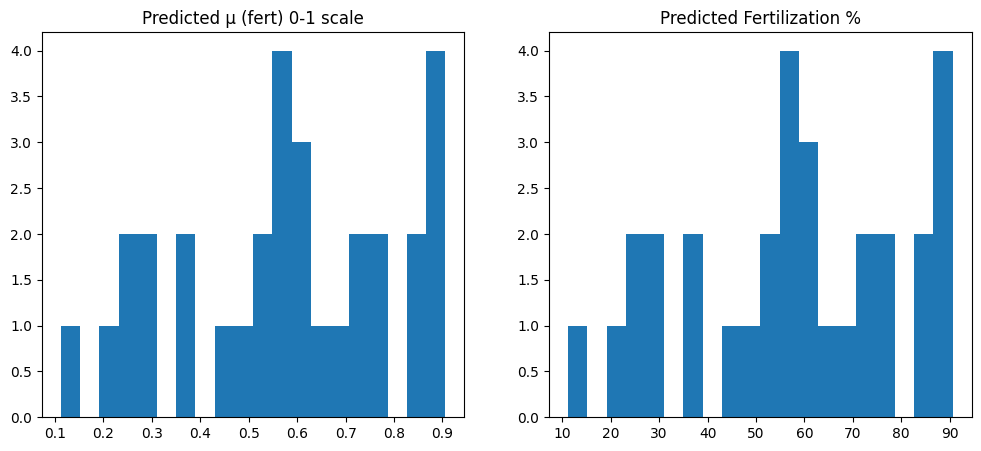

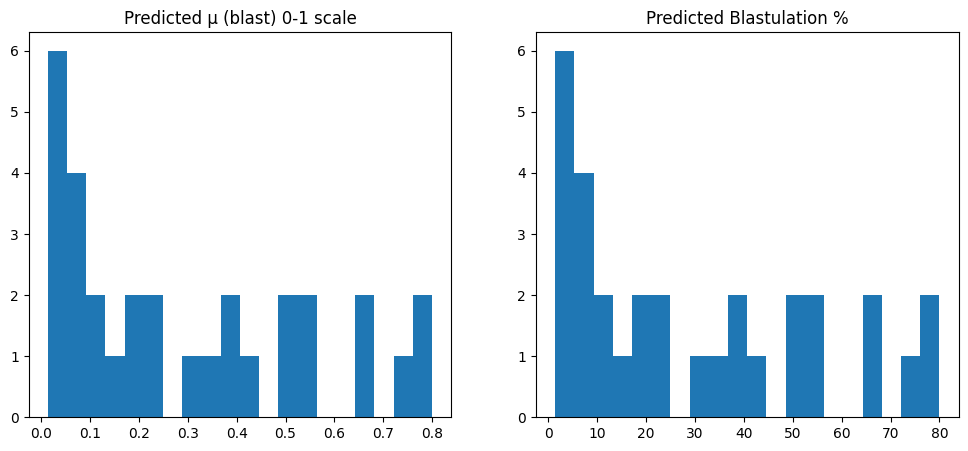

Sample y_fert_train (unscaled): [0.67 0.75 0.25 0.77 0.5  0.5  0.8  0.57 0.6  0.67]
Sample y_fert_train * 100: [67.       75.       25.       77.       50.       50.       80.
 57.       60.000004 67.      ]
Fertilization True (%) - min, max, mean: 1e-04 99.9999 60.032246
Fertilization Pred (%) - min, max, mean: 11.210396 90.58664 57.642338
Blastulation True (%) - min, max, mean: 1e-04 99.9999 33.032307
Blastulation Pred (%) - min, max, mean: 1.3774154 79.98945 30.015007


In [19]:
# --- Scale model outputs to realistic 0-100% range ---
# Option 1: fixed range
y_min_fert, y_max_fert = 0, 100
y_min_blast, y_max_blast = 0, 100

# 1. Get mu predictions from models
y_pred_mu_fert = fert_model.predict(x_val_scaled)[:, 0]
evaluate_percent(y_fert_val, y_pred_mu_fert, name="Fert (val)")

x_val_blast_enriched = np.concatenate([x_val_scaled , y_pred_mu_fert.reshape(-1,1)], 
    axis=1
)

y_pred_mu_blast = blast_model.predict(x_val_blast_enriched)[:, 0]
evaluate_percent(y_blast_val, y_pred_mu_blast, name="blast (val)")

# 2. Scale to percentage
y_pred_percent_fert = y_min_fert + (y_max_fert - y_min_fert) * y_pred_mu_fert
y_pred_percent_blast = y_min_blast + (y_max_blast - y_min_blast) * y_pred_mu_blast

# Fertilization
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_pred_mu_fert, bins=20)
plt.title("Predicted μ (fert) 0-1 scale")
plt.subplot(1,2,2)
plt.hist(y_pred_percent_fert, bins=20)
plt.title("Predicted Fertilization %")
plt.show()

# Blastulation
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(y_pred_mu_blast, bins=20)
plt.title("Predicted μ (blast) 0-1 scale")
plt.subplot(1,2,2)
plt.hist(y_pred_percent_blast, bins=20)
plt.title("Predicted Blastulation %")
plt.show()

print("Sample y_fert_train (unscaled):", y_fert_train[:10])
print("Sample y_fert_train * 100:", (y_fert_train * 100)[:10])
# Convert back to percentage scale
y_pred_fert_pct = y_pred_mu_fert * 100
y_pred_blast_pct = y_pred_mu_blast * 100

# Same for true labels
y_true_fert_pct = y_fert_val * 100
y_true_blast_pct = y_blast_val * 100

print("Fertilization True (%) - min, max, mean:", 
      np.min(y_true_fert_pct), np.max(y_true_fert_pct), np.mean(y_true_fert_pct))
print("Fertilization Pred (%) - min, max, mean:", 
      np.min(y_pred_fert_pct), np.max(y_pred_fert_pct), np.mean(y_pred_fert_pct))

print("Blastulation True (%) - min, max, mean:", 
      np.min(y_true_blast_pct), np.max(y_true_blast_pct), np.mean(y_true_blast_pct))
print("Blastulation Pred (%) - min, max, mean:", 
      np.min(y_pred_blast_pct), np.max(y_pred_blast_pct), np.mean(y_pred_blast_pct))



--- PHASE 5: Extended Evaluation ---

Testing on unseen test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Fert (test)  | MAE (pct): 27.012  | RMSE (pct): 33.483
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Blast (test)  | MAE (pct): 28.603  | RMSE (pct): 38.623

Evaluating on final holdout set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fert (holdout)  | MAE (pct): 31.309  | RMSE (pct): 38.243
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Blast (holdout)  | MAE (pct): 29.105  | RMSE (pct): 40.410
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


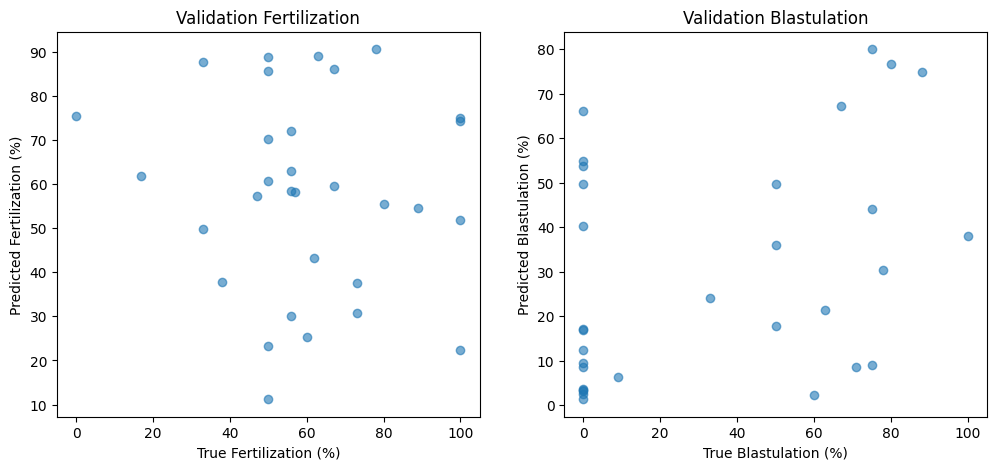

✓ Models and scaler successfully saved for deployment.


In [20]:
print("\n--- PHASE 5: Extended Evaluation ---")

# Evaluate on TEST set
print("\nTesting on unseen test set...")
fert_test_pred = fert_model.predict(x_test_scaled)[:, 0]
evaluate_percent(y_fert_test, fert_test_pred, name="Fert (test)")

x_test_blast_enriched = np.concatenate([x_test_scaled , fert_test_pred.reshape(-1,1)],
                                       axis=1
                                      )

blast_test_pred = blast_model.predict(x_test_blast_enriched)[:, 0]
evaluate_percent(y_blast_test, blast_test_pred, name="Blast (test)")

# Evaluate on HOLDOUT set (completely unseen)
print("\nEvaluating on final holdout set...")
fert_holdout_pred = fert_model.predict(x_holdout_scaled)[:, 0]
evaluate_percent(y_fert_holdout, fert_holdout_pred, name="Fert (holdout)")

x_holdout_blast_enriched = np.concatenate([x_holdout_scaled , fert_holdout_pred.reshape(-1,1)],
                                          axis=1
                                         )


blast_holdout_pred = blast_model.predict(x_holdout_blast_enriched)[:, 0]
evaluate_percent(y_blast_holdout, blast_holdout_pred, name="Blast (holdout)")


# Comparison plots for validation vs. predictions
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_fert_val * 100, fert_model.predict(x_val_scaled)[:,0]*100, alpha=0.6)
plt.xlabel("True Fertilization (%)")
plt.ylabel("Predicted Fertilization (%)")
plt.title("Validation Fertilization")

plt.subplot(1,2,2)
plt.scatter(y_blast_val * 100, blast_model.predict(x_val_blast_enriched)[:,0]*100, alpha=0.6)
plt.xlabel("True Blastulation (%)")
plt.ylabel("Predicted Blastulation (%)")
plt.title("Validation Blastulation")
plt.show()

# Save trained models
fert_model.save("final_fertilization_model.keras")
blast_model.save("final_blastulation_model.keras")

# Save scaler for future inference
joblib.dump(scaler, "scaler.pkl")

print("✓ Models and scaler successfully saved for deployment.")

In [21]:
def predict_rates(new_data_df):
    """
    Input: new_data_df (pandas DataFrame with same columns as x_train)
    Output: dict with Fertilization% and Blastulation%
    """
    # Load artifacts if needed
    from tensorflow.keras.models import load_model
    import joblib
    import numpy as np
    from scipy.special import expit

    scaler = joblib.load("scaler.pkl")
    fert_model = load_model("final_fertilization_model.keras", custom_objects={"beta_nll_loss": beta_nll_loss, "mae_mu": mae_mu, "OutputScaler": OutputScaler})
    blast_model = load_model("final_blastulation_model.keras", custom_objects={"beta_nll_loss": beta_nll_loss, "mae_mu": mae_mu, "OutputScaler": OutputScaler})

    # Scale new inputs
    new_scaled = scaler.transform(new_data_df)

    # Predict
    
    fert_pred_mu = fert_model.predict(new_scaled)[:,0]
    x_blast_enriched= np.concatenate([new_scaled, fert_pred_mu.reshape(-1,1)], axis=1)
    
    blast_pred_mu = blast_model.predict(x_blast_enriched)[:,0]

    fert_pred= fert_pred_mu*100
    blast_pred = blast_pred_mu*100
    
    return {
        "Fertilization_Rate(%)": np.mean(fert_pred),
        "Blastulation_Rate(%)": np.mean(blast_pred)
    }